In [10]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [11]:
base_dir = "/Users/thomasathey/Documents/mimlab/mouselight/kolodkin/sriram/files/ilastik_training/sriram-adipo-brain1-im3/"

3 total validation subvolumes
Thresh: 0.05 --- Total prec.: 0.907 total rec.: 0.996 w/1763/8319 total pos/neg voxels. F-score: 0.9492
Thresh: 0.10 --- Total prec.: 0.944 total rec.: 0.990 w/1763/8319 total pos/neg voxels. F-score: 0.9662
Thresh: 0.15 --- Total prec.: 0.955 total rec.: 0.984 w/1763/8319 total pos/neg voxels. F-score: 0.9693
Thresh: 0.20 --- Total prec.: 0.961 total rec.: 0.977 w/1763/8319 total pos/neg voxels. F-score: 0.9693
Thresh: 0.25 --- Total prec.: 0.966 total rec.: 0.971 w/1763/8319 total pos/neg voxels. F-score: 0.9680
Thresh: 0.30 --- Total prec.: 0.969 total rec.: 0.948 w/1763/8319 total pos/neg voxels. F-score: 0.9584
Thresh: 0.35 --- Total prec.: 0.971 total rec.: 0.917 w/1763/8319 total pos/neg voxels. F-score: 0.9431
Thresh: 0.40 --- Total prec.: 0.978 total rec.: 0.875 w/1763/8319 total pos/neg voxels. F-score: 0.9236
Thresh: 0.45 --- Total prec.: 0.988 total rec.: 0.819 w/1763/8319 total pos/neg voxels. F-score: 0.8955
Thresh: 0.50 --- Total prec.: 0.99

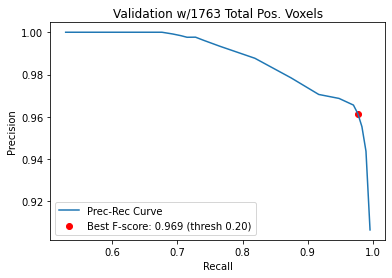

In [21]:
spacing = 0.05
thresholds = np.arange(spacing, 1.0, spacing)
precisions = []
recalls = []
best_fscore = 0

files = os.listdir(base_dir)
files = [base_dir + f for f in files if "val" in f]
files = [f for f in files if "_Probabilities.h5" in f]
print(f"{len(files)} total validation subvolumes")

for threshold in thresholds:
    true_pos_total = 0
    false_pos_total = 0
    true_labels_total = 0
    true_labels_total_neg = 0
    for fname_prob in files:

        fname_im = fname_prob[:-17] + ".h5"
        f = h5py.File(fname_im, "r")
        im = f.get("image_2channel")
        im_fg = im[:, :, :]

        fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
        f = h5py.File(fname_lab, "r")
        gt = f.get("exported_data")
        gt = gt[:, :, :, 0]
        pos_labels = gt == 2
        neg_labels = gt == 1

        f = h5py.File(fname_prob, "r")
        seg = f.get("exported_data")
        seg = seg[:, :, :, 1]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        true_labels_neg = np.sum(neg_labels)
        true_labels_total_neg += true_labels_neg

    precision_total = true_pos_total / (true_pos_total + false_pos_total)
    recall_total = true_pos_total / true_labels_total
    fscore = 2 / (1 / precision_total + 1 / recall_total)
    print(
        f"Thresh: {threshold:.2f} --- Total prec.: {precision_total:.3f} total rec.: {recall_total:.3f} w/{true_labels_total}/{true_labels_total_neg} total pos/neg voxels. F-score: {fscore:.4f}"
    )
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
        best_threshold = threshold
    precisions.append(precision_total)
    recalls.append(recall_total)
plt.plot(recalls, precisions, label="Prec-Rec Curve")
plt.scatter(
    [best_recall],
    [best_prec],
    c="red",
    label=f"Best F-score: {best_fscore:.3f} (thresh {best_threshold:.2f})",
)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title(f"Validation w/{true_labels_total} Total Pos. Voxels")
plt.legend()